## Strategy

> To trade support and resistance levels as well as some well known chart patterns

### *Signals*

> Bounce on resistance / pass support for 2 days = sell

> Bounce on support / pass resistance for 2 days = buy

> Head and shoulders trade


In [5]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime
from scipy.signal import argrelextrema


In [106]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()


,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Series 8,Series 9,Series 10,...,Series 20,Series 21,Series 22,Series 23,Series 24,Series 25,Series 26,Series 27,Series 28,Series 29
Day,,,,,,,,,,,,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.172920,100.589993,103.823464,98.644063,99.750482,106.614321,101.767999,100.732626,99.952576,100.227093,...,101.568951,99.730607,99.673906,99.409461,99.113705,100.012563,100.311565,99.887188,96.556886,97.922078
2,98.579911,98.767737,107.058757,97.936942,99.220660,110.602917,100.681776,100.383846,99.617067,100.246064,...,106.193229,101.541426,99.977798,99.577298,99.783831,99.682467,100.366287,99.902872,95.608782,100.000000
3,98.397809,97.087379,107.352843,100.000000,99.251805,113.424191,102.651998,101.569981,98.659381,101.230321,...,106.936416,100.938414,99.278429,99.055138,100.875486,99.637414,100.767880,100.216365,95.109780,100.000000
4,99.051233,99.716206,105.587978,99.703996,99.407530,113.715275,100.710685,101.081407,99.760755,101.040888,...,107.018993,101.448655,99.979185,99.602163,100.162127,100.379047,101.058262,100.323414,90.469062,99.480519


In [107]:
# Identifying turning points

def get_max_min(prices, smoothing, window_range):
    
    smooth_prices = prices.rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range].idxmin())  
            
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['Day'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')
    
    return max_min, maxima, minima

smoothing = 3
window = 10

[minmax, maxima, minima] = get_max_min(df['Series 1'], smoothing, window)
minmax.head()

,date,Series 1
day_num,,
11,11,100.482035
17,17,97.136867
23,23,89.739548
25,25,90.706678
40,40,97.654098


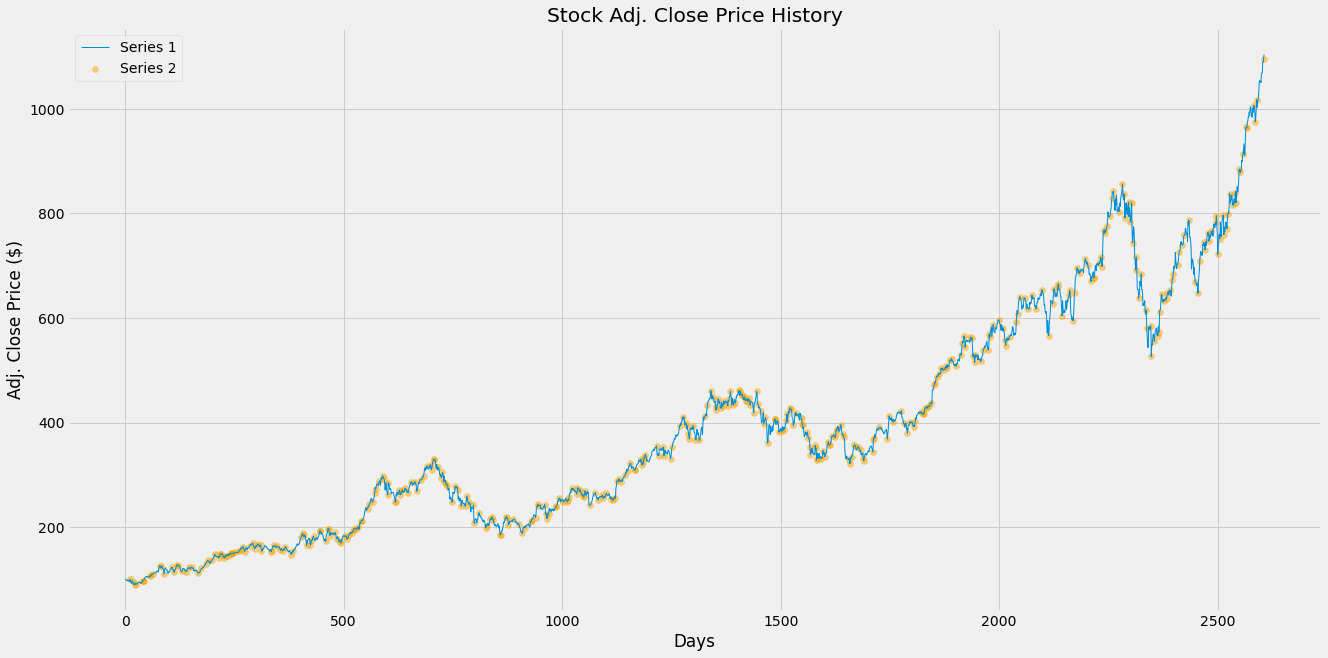

In [108]:
# plotting turning points
#Visualise the data

plt.figure(figsize=(20, 10))
plt.plot(df.reset_index()['Series 1'], linewidth = 1)
plt.scatter(minmax.index, minmax['Series 1'].values, color='orange', alpha=.5)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()


## Strategy 2

#### Identifying levels of support and resistance

In [255]:
# import necessary libraries
import matplotlib.dates as mpl_dates

start = 1000
end = 2000

# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df = df[start:end]
# df selected for testing purposes
data = df['Series 22'].iloc[0:]


In [256]:
#method 1: fractal candlestick pattern
# determine bullish fractal 

def is_support(df,i):  
    
    cond1 = df[i] < df[i-1]   
    cond2 = df[i] < df[i+1]   
    cond3 = df[i+1] < df[i+2]   
    cond4 = df[i-1] < df[i-2]  
    return (cond1 and cond2 and cond3 and cond4) 

# determine bearish fractal
def is_resistance(df,i):  
    
    cond1 = df[i] > df[i-1]   
    cond2 = df[i] > df[i+1]   
    cond3 = df[i+1] > df[i+2]   
    cond4 = df[i-1] > df[i-2]  
    return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
    ave =  np.mean(abs(df.iloc[2::] - df.iloc[0:-2]))    
    return np.sum([abs(value-level)<ave for _,level in levels])==0

# a list to store resistance and support levels
def leveler(series):
    levels = []

    data = df[series]
    
    for i in range(2, data.shape[0] - 2):  

        if is_support(data, i):    
            low = data[i]    
            if is_far_from_level(low, levels, data):      
                levels.append((i, low))  
        elif is_resistance(data, i):    
            high = data[i]    
            if is_far_from_level(high, levels, data):      
                levels.append((i, high))
    return levels


In [257]:
# for visualization
def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(10, 4))   
    ax.plot(df, linewidth=2, alpha=0.8, label=series)        
    
    for level in levels:        
        plt.hlines(level[1], xmin = df.reset_index()['Day'][level[0]-start], xmax = 
            max(df.reset_index()['Day']), colors='red', linestyle='--', linewidth=1)    
    plt.show()


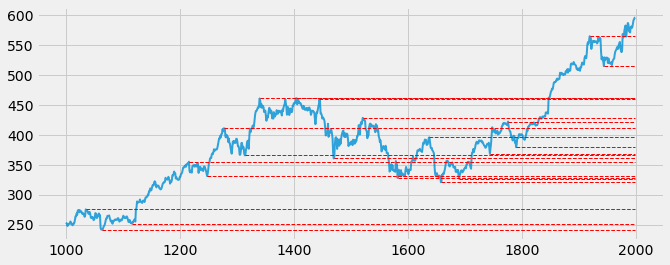

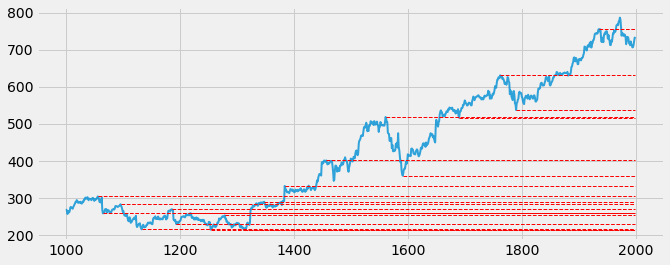

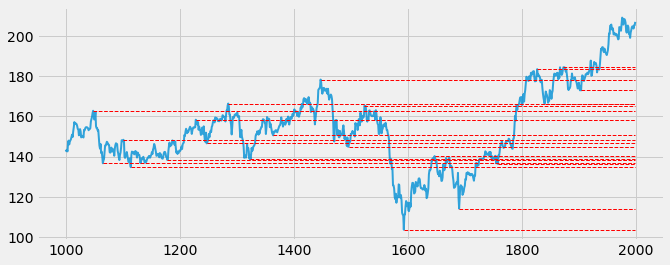

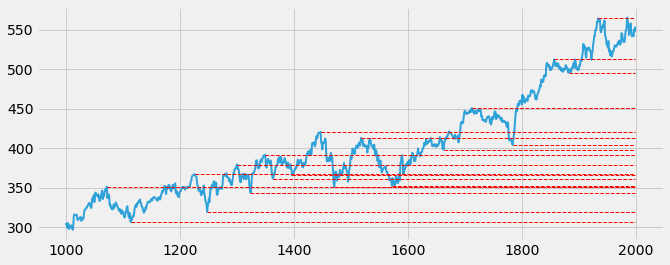

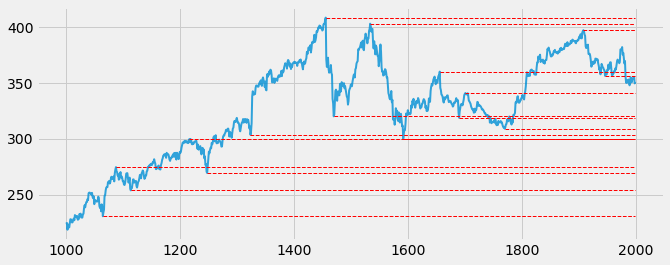

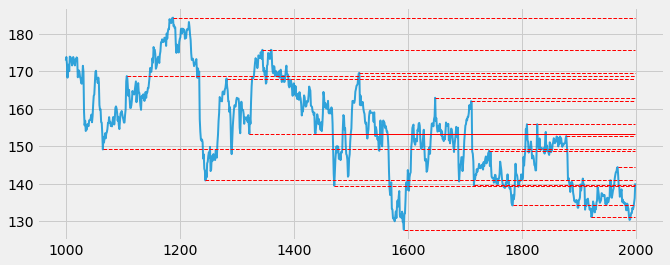

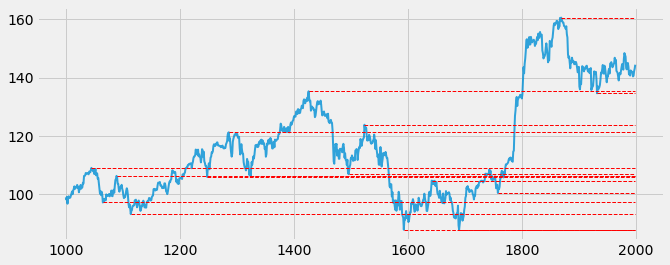

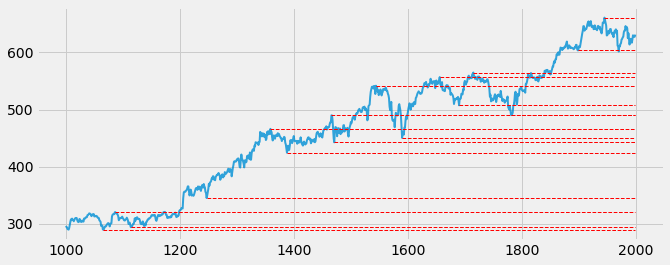

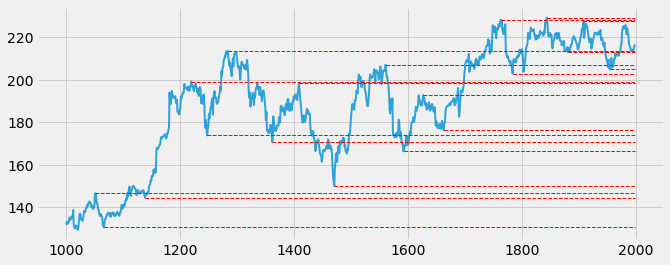

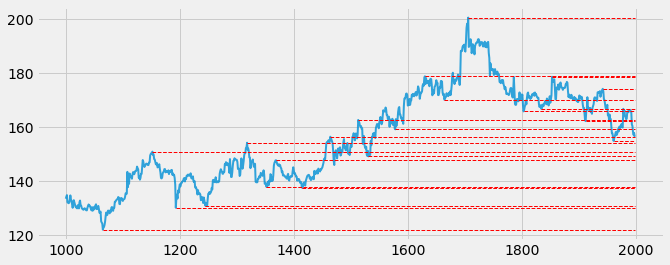

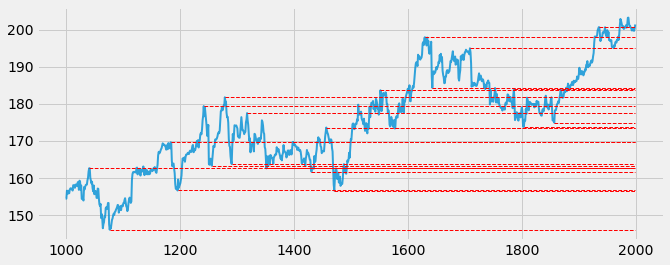

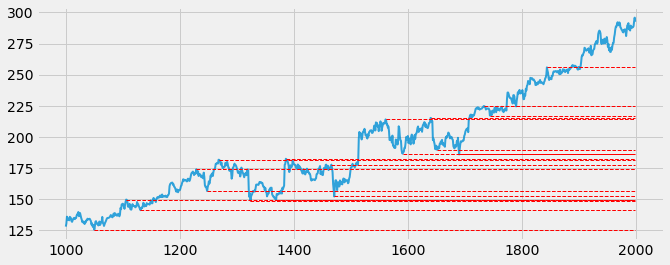

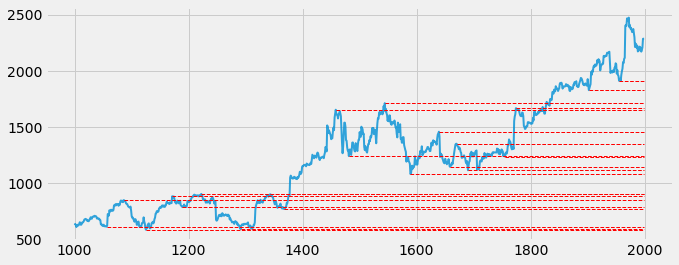

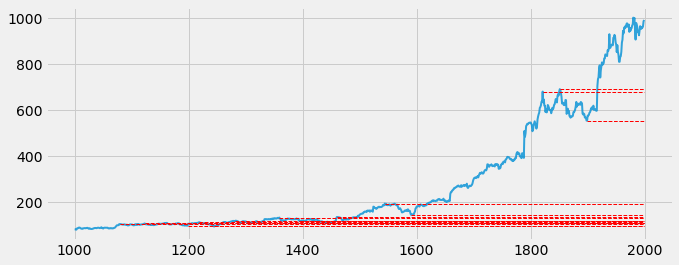

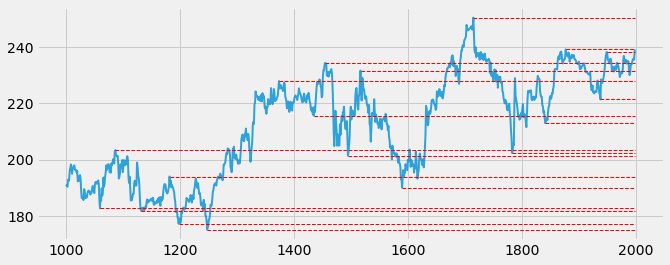

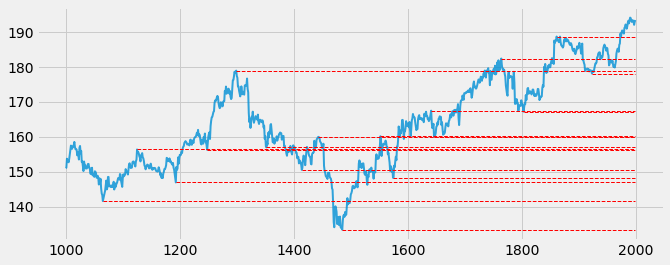

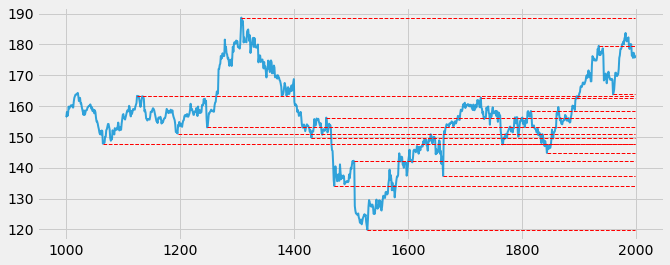

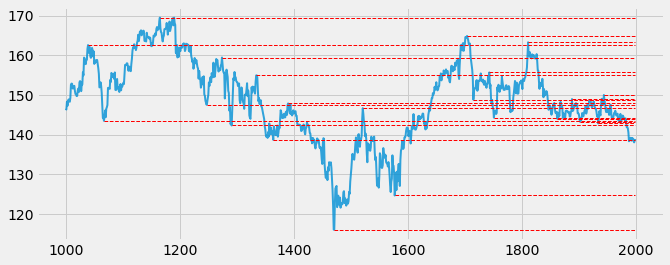

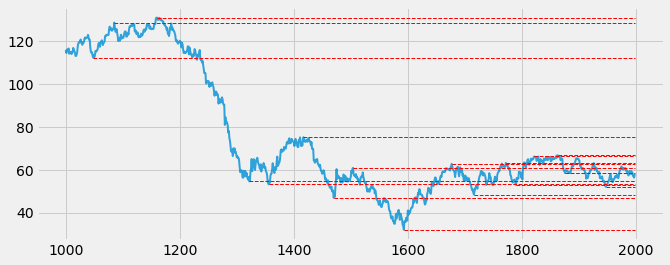

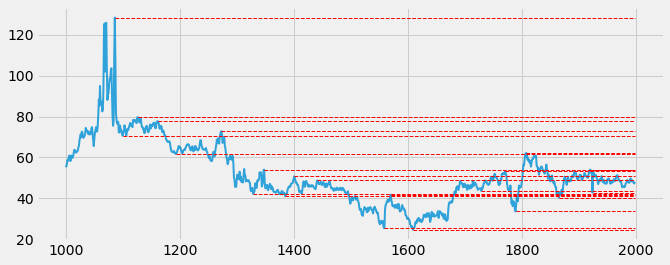

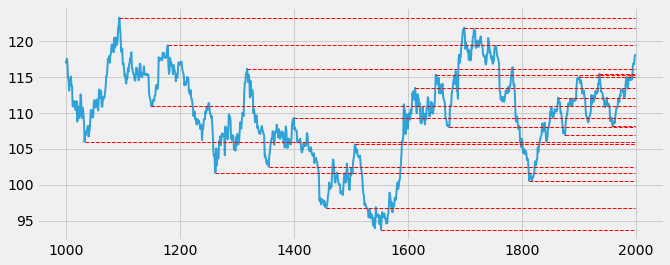

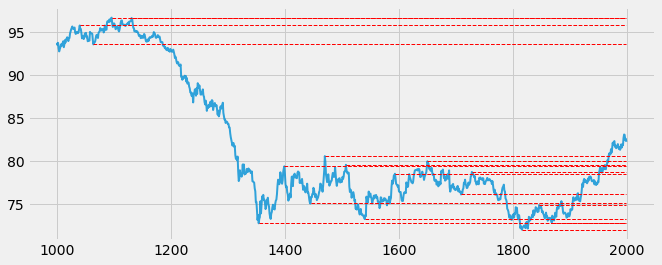

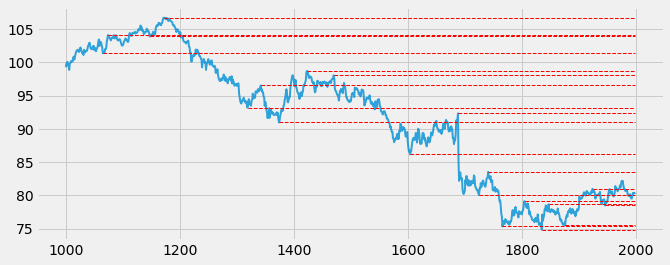

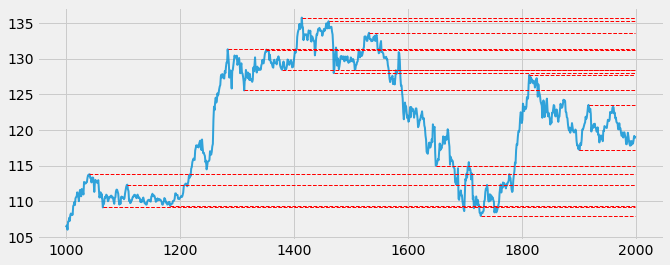

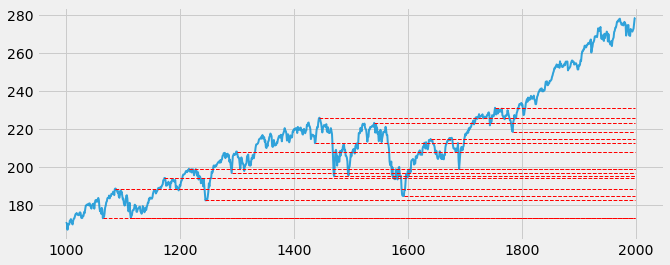

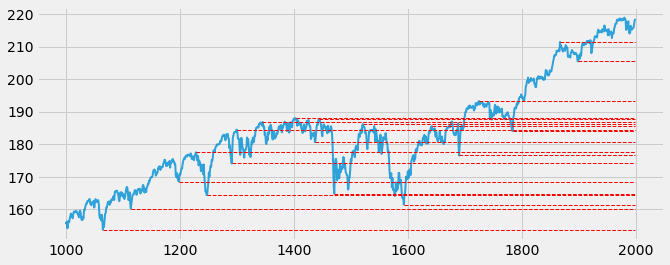

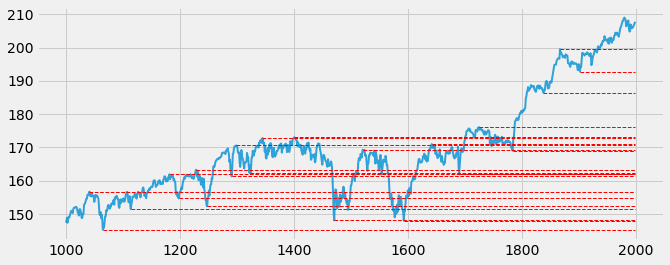

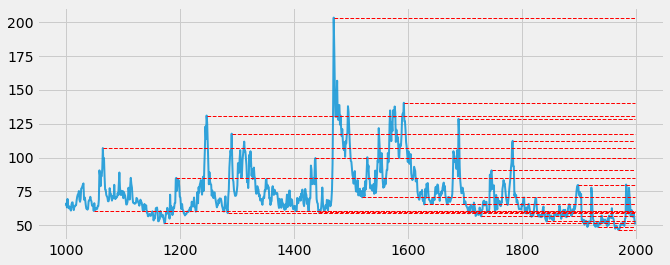

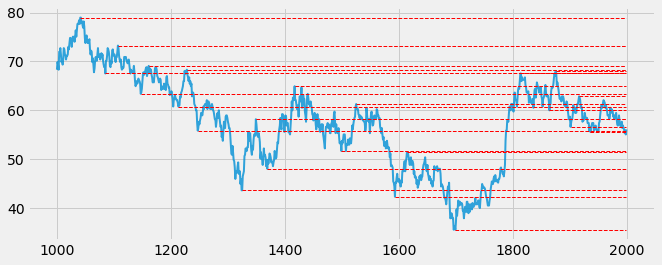

In [258]:
#method 2: window shifting method
#using the same symbol as the first example above

# window used to calculate supports and resistance
window = 30

def levelerv2(series):
    
    pivots = []
    max_list = []
    min_list = []
    
    data = df[series] 
    
    for i in range(window, len(data)-window):

        # taking a window of 9 candles
        high_range = data[i-window:i+window-1]
        current_max = high_range.max()

        # if we find a new maximum value, empty the max_list 
        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)

        # if the maximum value remains the same after shifting 5 times
        if len(max_list)==window and is_far_from_level(current_max,pivots,data):
            pivots.append((high_range.idxmax(), current_max))

        low_range = data[i-window:i+window]
        current_min = low_range.min()

        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)

        if len(min_list)==window and is_far_from_level(current_min,pivots,data):
            pivots.append((low_range.idxmin(), current_min))
    
    return pivots

# plotting for all series
for series in df.columns:
    plot_all(levelerv2(series), df[series])


In [259]:
levelerv2(series)

[(1041, 78.96103896103914),
 (1085, 67.53246753246776),
 (1107, 73.24675324675346),
 (1147, 63.37662337662357),
 (1161, 69.09090909090934),
 (1213, 60.77922077922098),
 (1228, 68.31168831168854),
 (1247, 55.844155844156006),
 (1324, 43.63636363636379),
 (1349, 58.181818181818365),
 (1369, 48.0519480519482),
 (1417, 64.93506493506513),
 (1499, 51.688311688311884),
 (1525, 61.29870129870154),
 (1593, 42.33766233766249),
 (1614, 51.4285714285716),
 (1699, 35.5844155844157),
 (1813, 67.53246753246772),
 (1864, 60.000000000000185),
 (1875, 68.05194805194823),
 (1901, 56.62337662337679),
 (1936, 55.58441558441573),
 (1916, 62.85714285714302)]